In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.nn.init import xavier_uniform_

In [2]:
logWriter = SummaryWriter("runs")

In [3]:
class Rescale(object) :
    def __call__(self, data) : 
        data.div_(torch.max(data))
        return data

In [4]:
class EdgeMaker(object) :
    def __call__(self, data) : 
        frame = data.numpy()[ : , : : -1, :]
        frame = frame.transpose(1, 2, 0)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobelY = cv2.Sobel(frame, cv2.CV_64F, 0, 1, ksize = 3)
        sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0, ksize = 3)
        output = sobelX + sobelY
        output = torch.from_numpy(output).float()
        return output.reshape(1, 32, 32)

In [5]:
transformTrain = transforms.Compose(
    [
     transforms.RandomRotation(degrees = 20), 
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(), 
     Rescale(),
    ])
transformTest = transforms.Compose(
    [transforms.ToTensor(),
    Rescale(), 
    ])

In [6]:
trainSet = datasets.CIFAR10(root = './data', train = True, download = True, transform = transformTrain)
testSet = datasets.CIFAR10(root = './data', train = False, download = True, transform = transformTest)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
batchSize = 16
trainLoader = DataLoader(dataset = trainSet, batch_size = batchSize, shuffle = True)
testLoader = DataLoader(dataset = testSet, batch_size = batchSize, shuffle = True)

In [9]:
itr = iter(trainLoader)

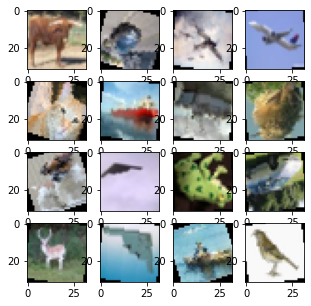

In [10]:
fig, ax = plt.subplots(4, 4, figsize=(5,5))

for i in range(4) :
    for j in range(4) :
        ax[i, j].imshow(np.transpose(itr.next()[0][i * 4 + j], (1, 2, 0)))


In [108]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding = 1)
        self.conv3 = nn.Conv2d(64, 32, 1, stride=1, padding = 0)
        self.batchNorm1 = nn.BatchNorm2d(32, affine=False)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding = 1)
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding = 1)
        self.conv6 = nn.Conv2d(128, 64, 1, stride=1, padding = 0)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1024, 512)  # 5*5 from image dimension
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.Softmax(dim = 1)
        print(self.state_dict()['conv1.weight'][0].mean())
        print(self.state_dict()['conv1.weight'][0].std())
        self.initializeModel(self.modules())
        print(self.state_dict()['conv1.weight'][0].mean())
        print(self.state_dict()['conv1.weight'][0].std())
        
        
    def initializeModel(self, modules) :
        for module in modules :
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
              xavier_uniform_(module.weight.data)
              if module.bias is not None:
                  nn.init.constant_(module.bias.data, 0)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.batchNorm1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def test(self, x):
        # Max pooling over a (2, 2) window
        print('Shape of input : ', x.shape)
        x = F.relu(self.conv1(x))
        print('Shape after first convolution : ', x.shape)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        print('Shape after second convolution : ', x.shape)
        x = F.relu(self.conv3(x))
        print('Shape after third convolution : ', x.shape)
        x = F.max_pool2d(x, 2)
        x = self.batchNorm1(x)
        print('Shape after first pooling : ', x.shape)
        x = F.relu(self.conv4(x))
        print('Shape after fourth convolution : ', x.shape)
        x = F.relu(self.conv5(x))
        x = self.dropout(x)
        print('Shape after fifth convolution : ', x.shape)
        x = F.relu(self.conv6(x))
        print('Shape after sixth convolution : ', x.shape)
        x = F.max_pool2d(x, 2)
        print('Shape after second pooling : ', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        print('Shape after flattening : ', x.shape)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ans = torch.empty(x.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(x[index])
        return ans

In [109]:
model = Net()

# PATH = 'savedModels/2021_12_30-23:45:24.pth'
# modelParams = torch.load(PATH)['params']
# trainingLosses = torch.load(PATH)['losses']
# model.load_state_dict(modelParams)

tensor(0.0169)
tensor(0.1156)
tensor(0.0030)
tensor(0.0800)


In [112]:
# logWriter.add_graph(model, itr.next()[0])

In [116]:
index = 1

itr = iter(trainLoader)
randomDataPoint = itr.next()

model.test(randomDataPoint[0])

Shape of input :  torch.Size([16, 3, 32, 32])
Shape after first convolution :  torch.Size([16, 32, 32, 32])
Shape after second convolution :  torch.Size([16, 64, 16, 16])
Shape after third convolution :  torch.Size([16, 32, 16, 16])
Shape after first pooling :  torch.Size([16, 32, 8, 8])
Shape after fourth convolution :  torch.Size([16, 64, 8, 8])
Shape after fifth convolution :  torch.Size([16, 128, 8, 8])
Shape after sixth convolution :  torch.Size([16, 64, 8, 8])
Shape after second pooling :  torch.Size([16, 64, 4, 4])
Shape after flattening :  torch.Size([16, 1024])


tensor([1., 6., 6., 2., 6., 6., 3., 1., 8., 1., 2., 1., 2., 8., 6., 8.])

In [117]:
def makeTrainStep(model, optimizer, lossFn) :
    
    def trainStep (xTrain, yTrain) :
        model.train()
        yPred = model(xTrain)
        loss = lossFn(yPred, yTrain)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        return loss.detach()
        
    return trainStep        

In [118]:
losses = []
epoch = 0

In [144]:
nEpochs = 70
learningRate= 0.001
lossFn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learningRate)

trainingStep = makeTrainStep(model, optimizer, lossFn)

while epoch < nEpochs : 
    print('Trainig pass : ', epoch + 1, ' of ', nEpochs, end = ' ')
    runningLoss = torch.zeros(1)
    for i, data in enumerate(trainLoader, 0):
        xBatch, yBatch = data
        loss = trainingStep(xBatch, yBatch)
        runningLoss += loss.item()
    logWriter.add_scalar('Loss (log)', torch.log(runningLoss), epoch)
    losses.append(torch.log(runningLoss))
    
    if (epoch + 1)%10 == 0 :
        totalPredictions = 0
        correctPredictions = 0
        wrongPred1 = []
        model.eval()
#         for xTestBatch, yTestBatch in testLoader :
#             yPred = model.predict(xTestBatch)
#             correctPredictions += torch.eq(yPred, yTestBatch).sum()
#             totalPredictions += batchSize
#         logWriter.add_scalar('Accuracy', correctPredictions/totalPredictions, epoch)
    print('Complete')
    epoch += 1
print('Training loop complete')

Trainig pass :  41  of  70 Complete
Trainig pass :  42  of  70 Complete
Trainig pass :  43  of  70 Complete
Trainig pass :  44  of  70 Complete
Trainig pass :  45  of  70 Complete
Trainig pass :  46  of  70 Complete
Trainig pass :  47  of  70 Complete
Trainig pass :  48  of  70 Complete
Trainig pass :  49  of  70 Complete
Trainig pass :  50  of  70 Complete
Trainig pass :  51  of  70 Complete
Trainig pass :  52  of  70 Complete
Trainig pass :  53  of  70 Complete
Trainig pass :  54  of  70 Complete
Trainig pass :  55  of  70 Complete
Trainig pass :  56  of  70 Complete
Trainig pass :  57  of  70 Complete
Trainig pass :  58  of  70 Complete
Trainig pass :  59  of  70 Complete
Trainig pass :  60  of  70 Complete
Trainig pass :  61  of  70 Complete
Trainig pass :  62  of  70 Complete
Trainig pass :  63  of  70 Complete
Trainig pass :  64  of  70 Complete
Trainig pass :  65  of  70 Complete
Trainig pass :  66  of  70 Complete
Trainig pass :  67  of  70 Complete
Trainig pass :  68  of  70 C

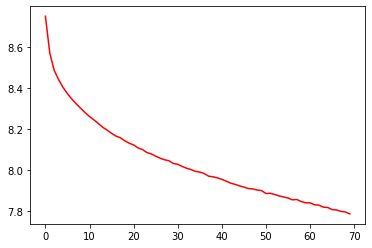

In [145]:
plt.plot(losses, color = 'red')

In [146]:
totalPredictions = 0
correctPredictions = 0
wrongPred1 = []
model.eval()
with torch.no_grad() :
    for xTrainBatch, yTrainBatch in trainLoader :
        yPred = model.forward(xTrainBatch)
    
        ans = torch.empty(yPred.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(yPred[index])

        correctPredictions += torch.eq(ans, yTrainBatch).sum()
        totalPredictions += batchSize
    print('Train Accuracy : ', correctPredictions/totalPredictions)
    
    totalPredictions = 0
    correctPredictions = 0
    
    for xTestBatch, yTestBatch in testLoader :
        yPred = model.forward(xTestBatch)
    
        ans = torch.empty(yPred.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(yPred[index])

        correctPredictions += torch.eq(ans, yTestBatch).sum()

        for i, sample in enumerate(ans, 0) : 
            if(ans[i] != yTestBatch[i]) :
                wrongPred1.append({'image' : xTestBatch[i].permute(1, 2, 0), 'answer' : yTestBatch[i], 'pred' : yPred[i]})
        totalPredictions += batchSize
    print('Test Accuracy : ', correctPredictions/totalPredictions)

Train Accuracy :  tensor(0.7290)
Test Accuracy :  tensor(0.7188)


Answer :  bird
torch.Size([1, 1, 10])


ValueError: only one element tensors can be converted to Python scalars

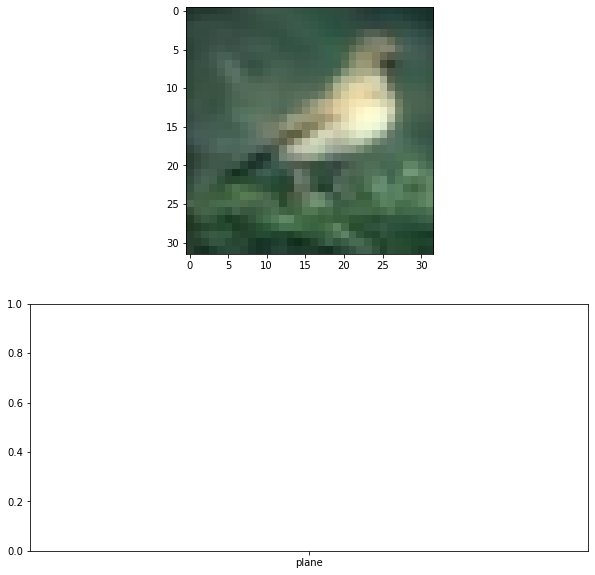

In [140]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))


i = 3
ax[0].imshow(wrongPred1[i]['image'])
print('Answer : ', classes[wrongPred1[i]['answer'].int()])
predProb = torch.from_numpy(wrongPred1[i]['pred'].reshape(1, 1, 10))
print(predProb.shape)
ax[1].bar(classes, model.softmax(predProb))

In [75]:
PATH = 'savedModels/' + datetime.now().strftime("%Y_%m_%d-%H:%M:%S") + '.pth'
torch.save({'params' : model.state_dict(), 'losses' : losses}, PATH)